In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
from scipy.stats import chisquare


%matplotlib inline


ModuleNotFoundError: No module named 'PIL'

In [4]:
import  PIL

ModuleNotFoundError: No module named 'PIL'

In [2]:
cd /Users/austinmcdonald/Desktop/SMFI-101918/slide1/spot2

/Users/austinmcdonald/Desktop/SMFI-101918/slide1/spot2


In [3]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files[0].split('_')[1].split('.')[0]
#sorted files so they are in order
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

In [4]:
ShapeSize = np.array(Image.open(files[0]))
ShapeSize.shape[0]

512

In [5]:
len(files)

500

In [8]:
#################################################################
#  FirstImage Should be an image from the stack of images, it is easiest to choose the first
#  eCoeff/eOffset are the units given in the tiff file that allow you to go from the "grey count" 
#  to acutual Photo Electrons PE. These can be found by opening a tiff with a text editing sofware and 
#  scrolling to the bottom.
#
#  The puropose of this function is to get the shape of the image and generate matricies of variables 
#  for later use
#################################################################
def Shaper(FirstImage,eCoeff,eOffset):
    ShapeSize = np.array(Image.open(FirstImage))
    Shape = ShapeSize.shape[0]
    eCoeffMatrix = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
    eOffsetMatrix = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
    EmptyData = np.zeros(Shape**2).reshape((Shape,Shape))
    return Shape, EmptyData, eCoeffMatrix, eOffsetMatrix

#################################################################
# datafiles is the list of images in the stack ( should be in order)
# Shape is the shape of the image 
# eCoeffMatrix / eOffsetMatrix are generated from Shaper above
# Frac is the percent of the images at the end of the stack you want to 
# use to generate the background profile 
#################################################################
def Image_Background(datafiles, Shape, eCoeffMatrix, eOffsetMatrix, Frac):
    xvs = np.arange(0,Shape)
    MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
    LL = len(datafiles)
    Fraction = int(LL*Frac)
    for x in range(LL-Fraction,LL):
        Images = np.array(Image.open(datafiles[x]))
        Images = eCoeffMatrix*(Images - eOffsetMatrix)  
        ImageFit = []
        for y in range(0,Shape):
            coefs = poly.polyfit(xvs,Images[y], 6) 
            ffit  = poly.polyval(xvs, coefs)
            ImageFit.append(ffit)
        MeanFit+=np.array(ImageFit)
    MeanFit = MeanFit/(Fraction)
    return MeanFit

#################################################################
# datafiles is the list of images in the stack ( should be in order)
# EmptyData is the empty matrix generated by Shaper 
# eCoeffMatrix / eOffsetMatrix are generated from Shaper above
# MeanFit is generated above 
# 
# This returns the summed stack where each image is background corrected 
# this is needed to find the high points with the next function
#################################################################

def Summed_Image(datafiles, EmptyData, MeanFit, eCoeffMatrix, eOffsetMatrix):
    LL = len(datafiles)
    for q in range(0,LL):
        Images = (np.array(Image.open(datafiles[q])) )
        Images = eCoeffMatrix*(Images - eOffsetMatrix)-MeanFit 
        EmptyData += Images
    return EmptyData

#################################################################
# datafiles is the list of images in the stack ( should be in order)
# This function scans the data and finds maxima in a region that is the size of 
# neighborhood_size. It looks for points in the neighborhood_size that are above
# the threshold. The threshold is defined as the mean of the data set + threshold_sigma
# deavations above the mean. the lower the threshold_sigma the more points you will get.
# also lowering the neighborhood_size will yeild more points
#
# Shape and EdgeCut are included so you can cut points out that are near the edge of the image
#################################################################
def Spot_finder(SummedData, neighborhood_size, threshold_sigma, Shape, EdgeCut):

    threshold = np.mean(SummedData)+threshold_sigma*np.std(SummedData)

    data_max = filters.maximum_filter(SummedData, neighborhood_size)
    maxima = (SummedData == data_max)
    data_min = filters.minimum_filter(SummedData, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    AllPairs = []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        y_center = (dy.start + dy.stop - 1)/2
        if x_center>EdgeCut and x_center<Shape-EdgeCut and y_center>EdgeCut and y_center<Shape-EdgeCut:
            x.append(x_center)
            y.append(y_center)
            AllPairs.append((x_center,y_center))
    return AllPairs, x, y


In [9]:
%%time
eCoeff = 0.01160
eOffset= 1917

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [10]:
eCoeff = 0.01160
eOffset= 1917

Shape, EmptyData, eCoeffMatrix, eOffsetMatrix = Shaper(files[0],eCoeff,eOffset)

MeanFit = Image_Background(files, Shape, eCoeffMatrix, eOffsetMatrix, 0.05)

Data = Summed_Image(files, EmptyData, MeanFit, eCoeffMatrix, eOffsetMatrix)
#Data[Data < 0] = 0

All,x_points,y_points =Spot_finder(Data, 20, 6, Shape, 20)

len(All)

36

In [11]:
print('All ',len(All))
print('x ',len(x_points))
print('y ',len(y_points))

All  36
x  36
y  36


In [12]:
All

[(383.0, 181.0),
 (381.0, 206.0),
 (363.0, 207.0),
 (421.0, 212.0),
 (403.0, 218.0),
 (346.0, 225.0),
 (372.0, 225.0),
 (390.0, 238.0),
 (412.0, 240.0),
 (365.0, 244.0),
 (442.0, 253.0),
 (349.0, 257.0),
 (412.0, 263.0),
 (455.0, 264.0),
 (320.0, 265.0),
 (397.0, 267.0),
 (352.0, 270.0),
 (376.0, 272.0),
 (387.0, 275.0),
 (476.0, 275.0),
 (424.0, 279.0),
 (325.0, 282.0),
 (369.0, 285.0),
 (358.0, 290.0),
 (397.0, 291.0),
 (343.0, 292.0),
 (409.0, 292.0),
 (443.0, 295.0),
 (370.0, 300.0),
 (404.0, 305.0),
 (386.0, 306.0),
 (431.0, 312.0),
 (361.0, 315.0),
 (384.0, 330.0),
 (415.0, 331.0),
 (358.0, 336.0)]

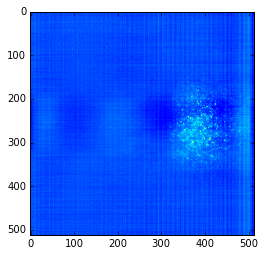

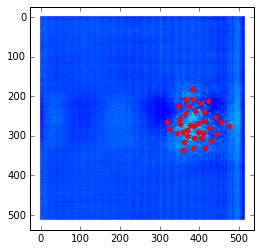

(455.0, 264.0)


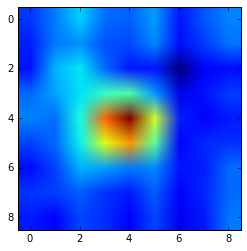

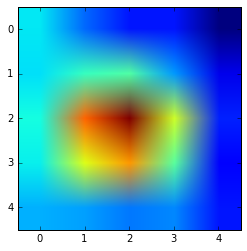

In [13]:
plt.imshow(Data)
plt.show()

plt.imshow(Data)
plt.scatter(x_points,y_points,color='r')
plt.show()

Xindex = int(All[13][0])
Yindex = int(All[13][1])
print(All[13])
Row = int(4) 
Col = int(4)
spot1 = np.array(Data[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])

plt.imshow(spot1)
plt.show()

spot = spot1[2:7,2:7]
plt.imshow(spot)
plt.show()

In [14]:
#################################################################
# Takes the datafiles and the IDed points and computes the area for each point
# through the whole stack
#################################################################
def Spot_Area(datafiles, MeanFit, eCoeffMatrix, eOffsetMatrix, All):
    LL = len(datafiles)
    SpotInfo = []
    for q in range(0,LL):
        Images = (np.array(Image.open(datafiles[q])) )
        Images = eCoeffMatrix*(Images - eOffsetMatrix)-MeanFit 
        Images[Images < 0] = 0 

        Row = int(4) # define the area to take around the spots
        Col = int(4) # define the area to take around the spots
        for we in range(0,len(All)):
            Xindex = int(All[we][0])
            Yindex = int(All[we][1])

            spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
            spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
            spot = spot1[2:7,2:7]
            SpotRemove = np.zeros(5**2).reshape((5,5))
            spot2[2:7,2:7]=SpotRemove
            spotB = spot2

            ATot = spot.sum()
            ATotB = spot2.sum()
            SpotInfo.append([Xindex,Yindex,ATot,ATotB])
    return SpotInfo

In [15]:
len(files)

500

In [16]:
AHH = Spot_Area(files, MeanFit, eCoeffMatrix, eOffsetMatrix, All)

In [17]:
HoldArea = np.array(AHH[2::36])[:,2]
#HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]

In [18]:
len(HoldArea)

500

In [19]:
Par = len(AllPairs)
AVG = 5
Signal = []
BackG  = []
SignalF = []
BackGF  = []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,4]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
    vals =np.arange(0,len(aa))

    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit)
    bac = np.array(aaB-ffit)

    SigF = np.array(HoldArea)
    bacF = np.array(HoldAreaB)

    Signal.append(Sig)
    BackG.append(bac)
    SignalF.append(SigF)
    BackGF.append(bacF)

NameError: name 'AllPairs' is not defined

## 

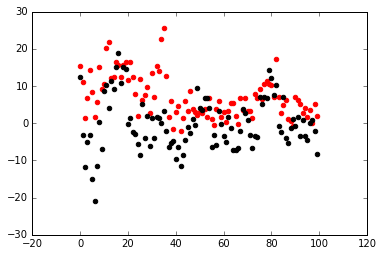

In [20]:
AVG = 5
Mnumb = 5
M = 36

HoldArea = np.array(AHH[M::36])[:,2]
HoldAreaB = np.array(AHH[M::36])[:,3]
aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
vals =np.arange(0,len(aa))

coefs = poly.polyfit(vals,aaB, 3)
ffit  = poly.polyval(vals, coefs)
Sig = np.array(aa-ffit*(25/56))
Bak = np.array(aaB-ffit)

xx = np.arange(500)
M = 25
plt.scatter(vals,Sig,color='r')
plt.scatter(vals,Bak,color='k')

plt.show()

In [44]:
len(np.arange(500))

500

In [17]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

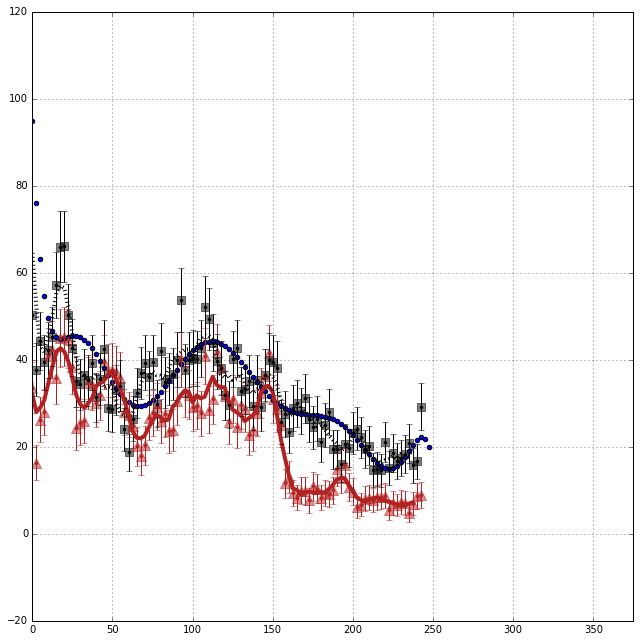

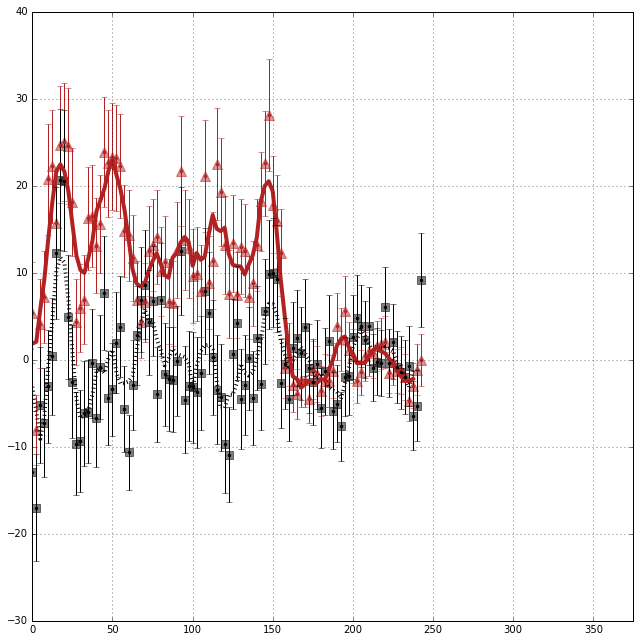

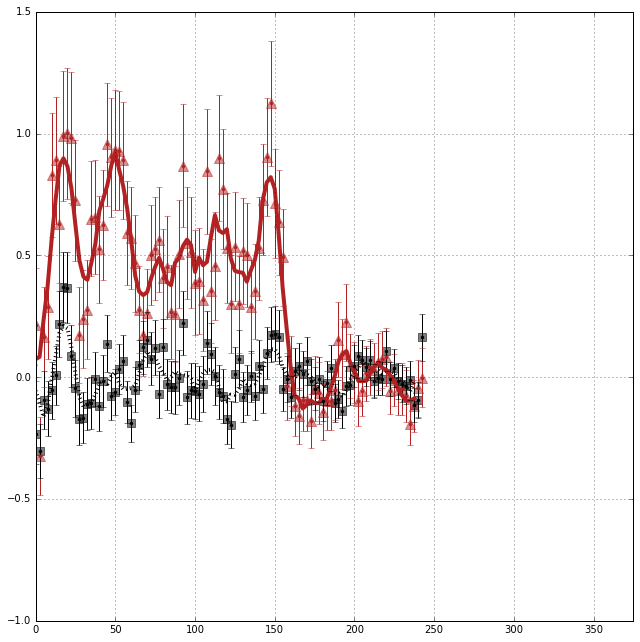

In [25]:
#Raw plot
M = 13

HoldArea = np.array(AHH[M::36])[:,2]
HoldAreaB = np.array(AHH[M::36])[:,3]

dataFull = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))
dataFullB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)

fig, ax = plt.subplots(figsize=(9,9))

b1 = ax.scatter(times-5,dataFullB, color='k',marker='s',label='Background', alpha=0.5,s=75)
bf1 = ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

s1 = ax.scatter(times-5,dataFull,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
sf1 = ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)

valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 9)
ffitF  = poly.polyval(valsF, coefsF)
plt.scatter(valsF,ffitF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)
ax.errorbar(times-5,dataFull,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataFullB,yerr=naerry,color='k',fmt='.')

ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#Subtracted plot
fig, ax = plt.subplots(figsize=(9,9))

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)

ax.scatter(times-5,dataSubB, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB,yerr=naerry,color='k',fmt='.')



ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#per pixel plot

fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')




ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()

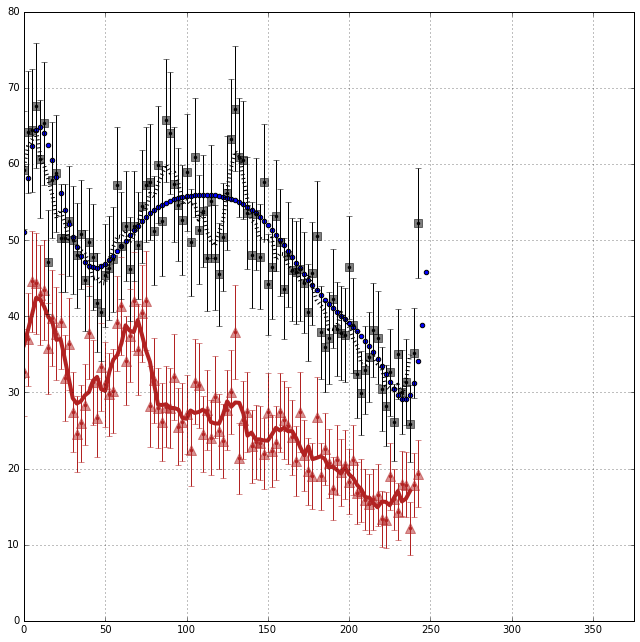

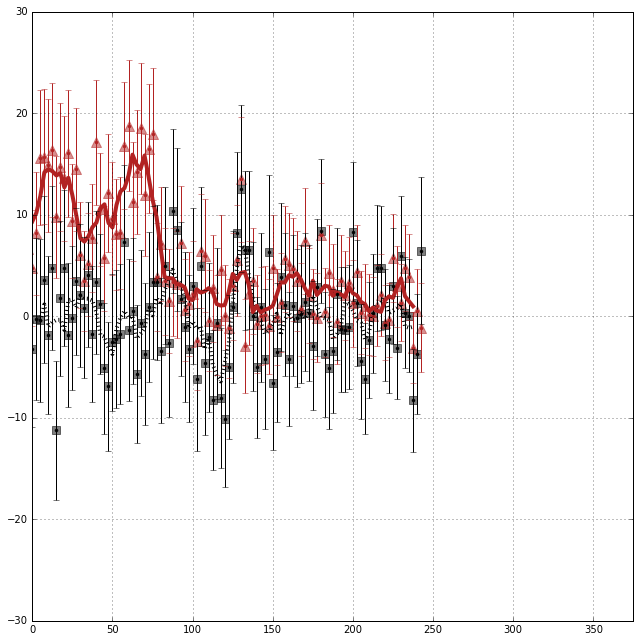

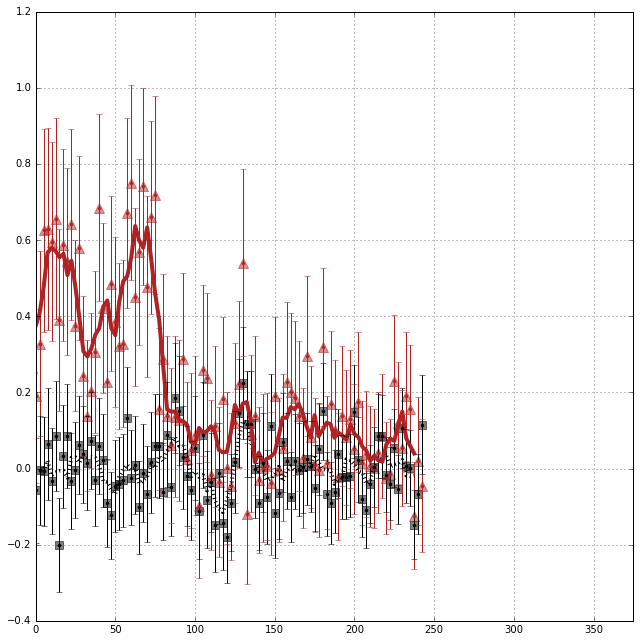

In [51]:
#Raw plot
M = 21

HoldArea = np.array(AHH[M::36])[:,2]
HoldAreaB = np.array(AHH[M::36])[:,3]

dataFull = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))
dataFullB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)

fig, ax = plt.subplots(figsize=(9,9))

b1 = ax.scatter(times-5,dataFullB, color='k',marker='s',label='Background', alpha=0.5,s=75)
bf1 = ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

s1 = ax.scatter(times-5,dataFull,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
sf1 = ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)

valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 9)
ffitF  = poly.polyval(valsF, coefsF)
plt.scatter(valsF,ffitF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)
ax.errorbar(times-5,dataFull,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataFullB,yerr=naerry,color='k',fmt='.')

ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#Subtracted plot
fig, ax = plt.subplots(figsize=(9,9))

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)

ax.scatter(times-5,dataSubB, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB,yerr=naerry,color='k',fmt='.')



ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#per pixel plot

fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')




ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()

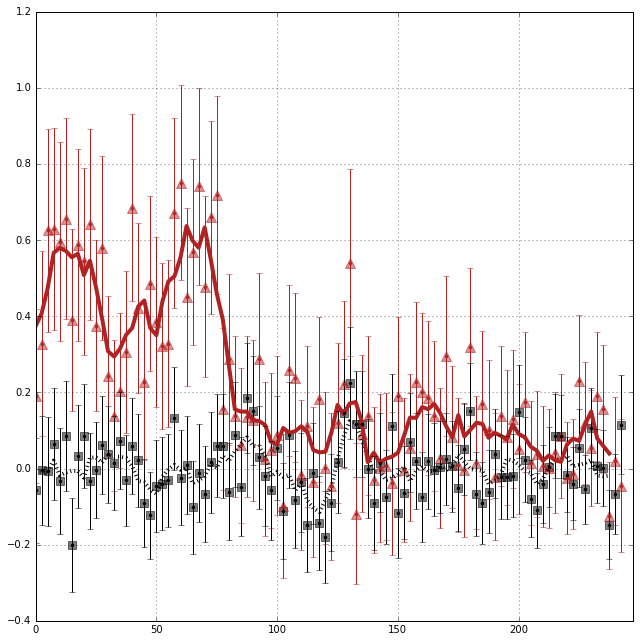

In [35]:
#Raw plot
M = 21

HoldArea = np.array(AHH[M::36])[:,2]
HoldAreaB = np.array(AHH[M::36])[:,3]

dataFull = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))
dataFullB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), 5))
times    = np.arange(0,len(dataFull))*2.5

#Atime = running_mean(times,K)
#Adat  = running_mean(dataFull,K)
#AdatB = running_mean(dataFullB,K)

fig, ax = plt.subplots(figsize=(9,9))



valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 9)
ffitF  = poly.polyval(valsF, coefsF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)


dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
K=5
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)



bknorm=56
signorm=25

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')




ax.set_xlim(0,max(times))
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Shape

In [ ]:
Xc=[]
Yc=[]
cut = 20
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>cut and XX<Shape-cut and YY>cut and YY<Shape-cut:
        Xc.append(XX)
        Yc.append(YY)
len(Xc)

In [ ]:
Pairs[0]

In [ ]:
eCoeff = 0.01160
eOffset= 1917

ShapeSize = np.array(Image.open(files[0]))
Shape = ShapeSize.shape[0]
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
DataSub = np.zeros(Shape**2).reshape((Shape,Shape))

neighborhood_size = 20

AllPairs =[]

xvs = np.arange(0,Shape)
MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
for x in range(190,200):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM) ######################################## 
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 6) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/10
Images=None

for q in range(0,200):
    Images = (np.array(Image.open(files[q])) )###################### - MeanFit
    Images = eCoeffM*(Images - eOffsetM)#-MeanFit      ######################################## 
    DataSub += Images


data = DataSub

threshold = np.mean(data)+6*np.std(data)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 

In [ ]:
len(AllPairs)

In [ ]:
AllPairs

In [ ]:
np.mean(DataSub)


In [ ]:
DataSub

In [ ]:
MeanFit*200

In [ ]:
np.mean(DataSub-MeanFit*200)

In [ ]:
'''Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<210 and YY>10 and YY<210:
        Xc.append(XX)
        Yc.append(YY)'''
Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    Xc.append(XX)
    Yc.append(YY)

In [ ]:
dd=np.array(DataSub)
plt.imshow(dd)
plt.show()
plt.imshow(dd)
plt.scatter(Xc,Yc,color='r')
plt.show()

In [ ]:
dd=np.array(DataSub-MeanFit*200)
plt.imshow(dd)
plt.show()

In [ ]:
tt = np.array(MeanFit)
plt.imshow(tt)
plt.show()